In [354]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
import re

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#from dstools import data_tools   #if plot decision tree surface

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

In [13]:
df = pd.read_pickle('../data_processeing/Yelp_Cuisine_Chinese.pkl')
print df.shape
df.head(2)

(27314, 98)


,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,...,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi,cuisine_Chinese
EDqCEAGXVGCH4FJXgqtjqg,979 Bloor Street W,"[{u'Alcohol': u'none'}, {u'Ambience': {u'roman...",EDqCEAGXVGCH4FJXgqtjqg,"[Restaurants, Pizza, Chicken Wings, Italian]",Toronto,"[Monday 11:0-2:0, Tuesday 11:0-2:0, Wednesday ...",1,43.661054,-79.429089,Pizza Pizza,...,False,False,NaN,NaN,NaN,NaN,False,NaN,NaN,1
GDnbt3isfhd57T1QqU6flg,11072 No Frank Lloyd Wright,"[{u'Alcohol': u'none'}, {u'Ambience': {u'roman...",GDnbt3isfhd57T1QqU6flg,"[Tex-Mex, Mexican, Fast Food, Restaurants]",Scottsdale,"[Monday 10:0-22:0, Tuesday 10:0-22:0, Wednesda...",1,33.586710,-111.835410,Taco Bell,...,False,False,NaN,NaN,NaN,NaN,False,NaN,NaN,1


In [29]:
#df.review_count.unique()

In [159]:
## Find and drop HairSpecializesIn
hair_columns = reduce(lambda x,y: x+y, map(lambda att: re.findall('HairSpecializesIn_.*', att), df.columns.values))
df.drop(hair_columns, axis=1, inplace=True)

In [160]:
df.shape

(27314, 90)

#### flaten attributes

In [161]:
df2 = df.copy()

In [162]:
df_att = df2.loc[ :, u'AcceptsInsurance':'WiFi'] # include 'WiFi'
att_type = {}
col_b = []
col_m = []
for i in range(df_att.shape[1]):
    temp = df_att.groupby(df_att.iloc[:,i]).size().keys()
    print temp.name, ': ', temp.values
    if set(temp.values) == set([False, True]) or set(temp.values).issubset(set([False, True])):
        att_type[temp.name] = 'b'
        col_b.append(temp.name)
    else:
        att_type[temp.name] = 'm'
        col_m.append(temp.name)

print len(col_b), len(col_m)
col_all = col_b + col_m

AcceptsInsurance :  [False True]
AgesAllowed :  [False True]
Alcohol :  [False True]
Ambience_casual :  [False True]
Ambience_classy :  ['beer_and_wine' 'full_bar' 'none']
Ambience_divey :  [False True]
Ambience_hipster :  ['average' 'loud' 'quiet' 'very_loud']
Ambience_intimate :  [False True]
Ambience_romantic :  ['casual' 'dressy' 'formal']
Ambience_touristy :  [False True]
Ambience_trendy :  [False True]
Ambience_upscale :  [False True]
BYOB :  [False True]
BYOBCorkage :  [False True]
BestNights_friday :  [False]
BestNights_monday :  [False True]
BestNights_saturday :  [False True]
BestNights_sunday :  [False True]
BestNights_thursday :  [False 'yes_corkage' 'yes_free']
BestNights_tuesday :  [False True]
BestNights_wednesday :  [False True]
BikeParking :  [False True]
BusinessAcceptsBitcoin :  [False True]
BusinessAcceptsCreditCards :  [False True]
BusinessParking_garage :  [False True]
BusinessParking_lot :  [False 'free' 'paid']
BusinessParking_street :  [False True]
BusinessPark

In [163]:
### join label with all the expanded"attributes" and "review count"
df_att_b = df2.loc[:,col_b].join(df[['review_count','cuisine_Chinese']])
df_att_b.head(1)

,AcceptsInsurance,AgesAllowed,Alcohol,Ambience_casual,Ambience_divey,Ambience_intimate,Ambience_touristy,Ambience_trendy,Ambience_upscale,BYOB,...,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi,review_count,cuisine_Chinese
EDqCEAGXVGCH4FJXgqtjqg,NaN,False,NaN,NaN,True,NaN,NaN,NaN,True,False,...,False,False,NaN,NaN,NaN,False,NaN,NaN,7,1


In [164]:
df_att_m = df2.loc[:,col_m].join(df[['review_count','cuisine_Chinese']])
df_att_m.head(1)

,Ambience_classy,Ambience_hipster,Ambience_romantic,BestNights_thursday,BusinessParking_lot,RestaurantsReservations,review_count,cuisine_Chinese
EDqCEAGXVGCH4FJXgqtjqg,none,quiet,casual,NaN,free,NaN,7,1


In [165]:
df_att_all = df_att.join(df[['review_count','cuisine_Chinese']])
df_att_all.head(1)

,AcceptsInsurance,AgesAllowed,Alcohol,Ambience_casual,Ambience_classy,Ambience_divey,Ambience_hipster,Ambience_intimate,Ambience_romantic,Ambience_touristy,...,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi,review_count,cuisine_Chinese
EDqCEAGXVGCH4FJXgqtjqg,NaN,False,NaN,NaN,none,True,quiet,NaN,casual,NaN,...,False,NaN,NaN,NaN,NaN,False,NaN,NaN,7,1


In [166]:
df_att_all.shape

(27314, 75)

In [167]:
df_att_all_filled = df_att_all.fillna(value='none')
df_att_all_filled.head(3)

,AcceptsInsurance,AgesAllowed,Alcohol,Ambience_casual,Ambience_classy,Ambience_divey,Ambience_hipster,Ambience_intimate,Ambience_romantic,Ambience_touristy,...,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi,review_count,cuisine_Chinese
EDqCEAGXVGCH4FJXgqtjqg,none,False,none,none,none,True,quiet,none,casual,none,...,False,none,none,none,none,False,none,none,7,1
GDnbt3isfhd57T1QqU6flg,none,False,none,none,none,False,quiet,none,casual,none,...,False,none,none,none,none,False,none,none,9,1
a1Ba6XeIOP48e64YFD0dMw,none,none,none,none,none,none,none,none,none,none,...,none,none,none,none,none,none,none,none,3,0


In [168]:
## transformed certain columns to BINARY varibales #####
df_chin_bi = pd.get_dummies(df_att_all_filled, \
                            prefix=col_all, prefix_sep='_', dummy_na=False, \
                            columns=col_all, sparse=False, drop_first=False)

In [169]:
## change column order
df_chin_bi = df_chin_bi.loc[:,['cuisine_Chinese','review_count'] + list(df_chin_bi.columns.values[2:])]

In [170]:
df_chin_bi.head(2)

,cuisine_Chinese,review_count,AcceptsInsurance_False,AcceptsInsurance_True,AcceptsInsurance_none,AgesAllowed_False,AgesAllowed_True,AgesAllowed_none,Alcohol_False,Alcohol_True,...,BestNights_thursday_yes_corkage,BestNights_thursday_yes_free,BusinessParking_lot_False,BusinessParking_lot_free,BusinessParking_lot_none,BusinessParking_lot_paid,RestaurantsReservations_False,RestaurantsReservations_True,RestaurantsReservations_none,RestaurantsReservations_outdoor
EDqCEAGXVGCH4FJXgqtjqg,1,7,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
GDnbt3isfhd57T1QqU6flg,1,9,0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [171]:
df_chin_bi.shape

(27314, 226)

In [172]:
# Split training(labeled) and test(unlabled) 
df_chin_train = df_chin_bi[df_chin_bi['cuisine_Chinese'] != 0]
df_chin_test = df_chin_bi[df_chin_bi['cuisine_Chinese'] == 0]

In [173]:
## Separate X(feature) and Y(traget) for training set
X = df_chin_train.ix[:, 1:]
Y = df_chin_train['cuisine_Chinese'].apply(lambda n: n-1)

In [472]:
X_train, X_vali, Y_train, Y_vali = train_test_split(
    X, Y, train_size=0.7, random_state=90) #Use random_state to fix samples

## Logistic Regression

#### Parameter tuning

In [391]:
# panalty and C value tuning
penalties = ['l1', 'l2'] 
C_values = sorted([np.exp(a*5) for a in np.linspace(-2,2,15)])
C_values

[4.5399929762484854e-05,
 0.00018944182523289392,
 0.00079049032311996614,
 0.0032985057559390941,
 0.01376378673305039,
 0.057432619267617294,
 0.23965103644177568,
 1.0,
 4.1727338835980934,
 17.41170806332763,
 72.654424207165334,
 303.16757768254888,
 1265.03762380433,
 5278.6653568747415,
 22026.465794806718]

In [392]:
# pick train test split ratio as 0.7

# LR GridSearch 1

# tuning hyper parameter
tuned_parameters_LR = {'C': C_values,
                       'penalty': penalties} 

lr = LogisticRegression(random_state=99)
gr_lr = GridSearchCV(lr, param_grid=tuned_parameters_LR, cv=5, scoring="roc_auc")
gr_lr.fit(X_train, Y_train)

gr_lr_auc_scores = cross_val_score(gr_lr, X, Y, scoring="roc_auc", cv=5)

print ( "Logistic regression training size(0.7): Mean AUC %.4f\n" % (np.mean(gr_lr_auc_scores)))

print "Best parameters set found:"
print gr_lr.best_params_
print"Gridsearch Scores: "
print gr_lr.score(X_vali, Y_vali)

means = gr_lr.cv_results_['mean_test_score']
stds = gr_lr.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gr_lr.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Logistic regression training size(0.7): Mean AUC 0.7368

Best parameters set found:
{'penalty': 'l1', 'C': 1.0}
Gridsearch Scores: 
0.730713489409
0.507 (+/-0.036) for {'penalty': 'l1', 'C': 4.5399929762484854e-05}
0.504 (+/-0.045) for {'penalty': 'l2', 'C': 4.5399929762484854e-05}
0.507 (+/-0.036) for {'penalty': 'l1', 'C': 0.00018944182523289392}
0.640 (+/-0.046) for {'penalty': 'l2', 'C': 0.00018944182523289392}
0.507 (+/-0.036) for {'penalty': 'l1', 'C': 0.00079049032311996614}
0.703 (+/-0.028) for {'penalty': 'l2', 'C': 0.00079049032311996614}
0.630 (+/-0.041) for {'penalty': 'l1', 'C': 0.0032985057559390941}
0.720 (+/-0.019) for {'penalty': 'l2', 'C': 0.0032985057559390941}
0.681 (+/-0.023) for {'penalty': 'l1', 'C': 0.01376378673305039}
0.731 (+/-0.018) for {'penalty': 'l2', 'C': 0.01376378673305039}
0.730 (+/-0.012) for {'penalty': 'l1', 'C': 0.057432619267617294}
0.736 (+/-0.018) for {'penalty': 'l2', 'C': 0.057432619267617294}
0.736 (+/-0.019) for {'penalty': 'l1', 'C': 0.239

In [393]:
p_opt = gr_lr.best_params_.values()[0]
c_opt = gr_lr.best_params_.values()[1]

## Decision Tree Classifier

In [477]:
mdepth_values = sorted([int(a) for a in np.linspace(1, 40, 10)])
print mdepth_values
mss_values = sorted([int(a) for a in np.linspace(100, 400, 10)])
print mss_values
msl_values = sorted([int(a) for a in np.linspace(1, 50, 10)])
print msl_values

[1, 5, 9, 14, 18, 22, 27, 31, 35, 40]
[100, 133, 166, 200, 233, 266, 300, 333, 366, 400]
[1, 6, 11, 17, 22, 28, 33, 39, 44, 50]


In [480]:
# tuning hyperparameter
tuned_parameters_DT = {'max_depth': mdepth_values,
                       'min_samples_split': mss_values,
                       'min_samples_leaf':msl_values
                       }

dt = DecisionTreeClassifier(criterion='entropy', random_state=99)
gr_dt = GridSearchCV(dt, param_grid=tuned_parameters_DT, cv=5, scoring="roc_auc")
gr_dt.fit(X_train, Y_train)

gr_dt_auc_scores = cross_val_score(gr_dt, X, Y, scoring="roc_auc", cv=5)

print ( "Decision Tree with training size(0.7): Mean AUC %.4f\n" % (np.mean(gr_dt_auc_scores)))

print "Best parameters set found:"
print gr_dt.best_params_
print"Gridsearch Scores: "
print gr_dt.score(X_vali, Y_vali)

means = gr_dt.cv_results_['mean_test_score']
stds = gr_dt.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gr_dt.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Decision Tree with training size(0.7): Mean AUC 0.7180

Best parameters set found:
{'min_samples_split': 266, 'max_depth': 14, 'min_samples_leaf': 28}
Gridsearch Scores: 
0.719029969178
0.584 (+/-0.042) for {'min_samples_split': 100, 'max_depth': 1, 'min_samples_leaf': 1}
0.584 (+/-0.042) for {'min_samples_split': 133, 'max_depth': 1, 'min_samples_leaf': 1}
0.584 (+/-0.042) for {'min_samples_split': 166, 'max_depth': 1, 'min_samples_leaf': 1}
0.584 (+/-0.042) for {'min_samples_split': 200, 'max_depth': 1, 'min_samples_leaf': 1}
0.584 (+/-0.042) for {'min_samples_split': 233, 'max_depth': 1, 'min_samples_leaf': 1}
0.584 (+/-0.042) for {'min_samples_split': 266, 'max_depth': 1, 'min_samples_leaf': 1}
0.584 (+/-0.042) for {'min_samples_split': 300, 'max_depth': 1, 'min_samples_leaf': 1}
0.584 (+/-0.042) for {'min_samples_split': 333, 'max_depth': 1, 'min_samples_leaf': 1}
0.584 (+/-0.042) for {'min_samples_split': 366, 'max_depth': 1, 'min_samples_leaf': 1}
0.584 (+/-0.042) for {'min_samp

In [481]:
md_opt = gr_dt.best_params_.values()[0]
mss_opt = gr_dt.best_params_.values()[1]
msl_opt = gr_dt.best_params_.values()[2]

## SVM Classifier

In [222]:
X_train.head(2)

,review_count,AcceptsInsurance_False,AcceptsInsurance_True,AcceptsInsurance_none,AgesAllowed_False,AgesAllowed_True,AgesAllowed_none,Alcohol_False,Alcohol_True,Alcohol_none,...,BestNights_thursday_yes_corkage,BestNights_thursday_yes_free,BusinessParking_lot_False,BusinessParking_lot_free,BusinessParking_lot_none,BusinessParking_lot_paid,RestaurantsReservations_False,RestaurantsReservations_True,RestaurantsReservations_none,RestaurantsReservations_outdoor
nKeGPmH5dYNVL5AyAItuKg,106,0,0,1,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
DKglcPMQnoEksCWeMkv31Q,16,0,0,1,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0


### Scaling selected columns(feature variables)

In [246]:
## Scale transforming
def scale_variables(df_X, columns=None):
    if columns:
        X_unchanged = df_X.loc[:, df_X.columns[~df_X.columns.isin(columns)]]
        
        if len(columns) == 1:
        # scale X
            scaler = preprocessing.StandardScaler().fit(df_X[columns[0]].values.reshape(-1,1))
            X_p = scaler.transform(df_X[columns[0]].values.reshape(-1,1))
            X_std = np.hstack((X_p, X_unchanged))

        else:
            scaler = preprocessing.StandardScaler().fit(df_X.loc[:, columns])
            X_p = scaler.transform(df_X.loc[:, columns])
            X_std = np.hstack((X_p, X_unchanged))
    else:
        scaler = preprocessing.StandardScaler().fit(df_X)
        X_std = scaler.transform(df_X)  
        
    return X_std

In [259]:
X_train_std = scale_variables(X_train, columns=['review_count'])
X_vali_std = scale_variables(X_vali, ['review_count'])
X_all_std = scale_variables(X, columns=['review_count'])

In [248]:
X_train_std

array([[ 0.12075868,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.41613288,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.26103087,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ..., 
       [-0.41016742,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.4757875 ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.3505128 ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ]])

In [249]:
X_train.shape

(13199, 225)

In [396]:
## Using LinearSVC ##
######################
# tuning hyperparameter
tuned_parameters_SVC = {'C': C_values} 

svc = LinearSVC(random_state=99)
gr_svc = GridSearchCV(svc, param_grid=tuned_parameters_SVC, cv=5, scoring="roc_auc")
gr_svc.fit(X_train_std, Y_train)

gr_svc_auc_scores = cross_val_score(gr_svc, X_all_std, Y, scoring="roc_auc", cv=5)

print ( "SVM Classifier with training size(0.7): Mean AUC %.4f\n" % (np.mean(gr_svc_auc_scores)))

print "Best parameters set found:"
print gr_svc.best_params_
print"Gridsearch Scores: "
print gr_svc.score(X_vali_std, Y_vali)

means = gr_svc.cv_results_['mean_test_score']
stds = gr_svc.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, gr_svc.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

SVM Classifier with training size(0.7): Mean AUC 0.7344

Best parameters set found:
{'C': 0.23965103644177568}
Gridsearch Scores: 
0.728751000066
0.694 (+/-0.029) for {'C': 4.5399929762484854e-05}
0.719 (+/-0.018) for {'C': 0.00018944182523289392}
0.730 (+/-0.018) for {'C': 0.00079049032311996614}
0.734 (+/-0.019) for {'C': 0.0032985057559390941}
0.735 (+/-0.019) for {'C': 0.01376378673305039}
0.735 (+/-0.017) for {'C': 0.057432619267617294}
0.735 (+/-0.017) for {'C': 0.23965103644177568}
0.735 (+/-0.016) for {'C': 1.0}
0.726 (+/-0.012) for {'C': 4.1727338835980934}
0.682 (+/-0.049) for {'C': 17.41170806332763}
0.664 (+/-0.062) for {'C': 72.654424207165334}
0.662 (+/-0.038) for {'C': 303.16757768254888}
0.642 (+/-0.057) for {'C': 1265.03762380433}
0.648 (+/-0.068) for {'C': 5278.6653568747415}
0.647 (+/-0.068) for {'C': 22026.465794806718}


In [397]:
c_svc_opt = gr_svc.best_params_.values()[0]

In [398]:
c_svc_opt

0.23965103644177568

---------
## Compare Models: LR & DT & SVM
### Models with optimal parameters

In [482]:
models = []
labels = []

# fit LR model
lr_opt = LogisticRegression(C=c_opt, penalty=p_opt, random_state=99)
lr_opt.fit(X_train, Y_train)
models.append(lr_opt)
labels.append('Logistic Regression')

# fit DT model
dt_opt = DecisionTreeClassifier(criterion='entropy', random_state=99, \
                                max_depth=md_opt, min_samples_split=mss_opt, min_samples_leaf=msl_opt)
dt_opt.fit(X_train, Y_train)
models.append(dt_opt)
labels.append('Decision Tree')

# fit LinearSVM model
svm_opt = LinearSVC(penalty='l2', C=c_svc_opt, random_state=99)  ## how to use "rbf" ??
svm_opt.fit(X_train_std, Y_train)

svm_cali = CalibratedClassifierCV(base_estimator=svm_opt)  # for calculating probability
svm_cali.fit(X_train_std, Y_train)
models.append([svm_opt, svm_cali])
labels.append(['LinearSVC', 'SVM Calibrated Classifier'])

In [483]:
models

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=99, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=266,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=28,
             min_samples_split=14, min_weight_fraction_leaf=0.0,
             presort=False, random_state=99, splitter='best'),
 [LinearSVC(C=0.23965103644177568, class_weight=None, dual=True,
       fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
       max_iter=1000, multi_class='ovr', penalty='l2', random_state=99,
       tol=0.0001, verbose=0),
  CalibratedClassifierCV(base_estimator=LinearSVC(C=0.23965103644177568, class_weight=None, dual=True,
       fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
 

In [484]:
## Reference: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

def plot_coefficients(classifier, label, feature_names, top_features=20):
    try:
        coef = classifier.coef_.ravel()
    except AttributeError:
        coef = classifier.feature_importances_
        pass
        
    top_positive_coefficients = np.argsort(coef)[-top_features:]   
    top_negative_coefficients = np.argsort(coef)[:top_features]
    if coef[top_negative_coefficients].min() != 0:
        top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    else:
        top_coefficients = top_positive_coefficients
        top_negative_coefficients = []
    
    # create plot
    plt.figure(figsize=(16, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(len(top_coefficients)), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + len(top_coefficients)), feature_names[top_coefficients], rotation=60, ha='right')
    plt.title('Top {} Important Features - {}'.format(top_features, label), size=20)
    plt.show()
    
    if len(top_negative_coefficients) != 0:
        df = pd.DataFrame(np.asarray([feature_names[top_positive_coefficients], coef[top_positive_coefficients],\
                           feature_names[top_negative_coefficients], coef[top_negative_coefficients]]).T, \
                          columns=['top_pos_features', 'top_pos_coef', 'top_neg_features', 'top_neg_coef'])
    else:
        df = pd.DataFrame(np.asarray([feature_names[top_positive_coefficients], coef[top_positive_coefficients]]).T,\
                          columns=['top_pos_features', 'top_pos_coef'])
    
    return label, df

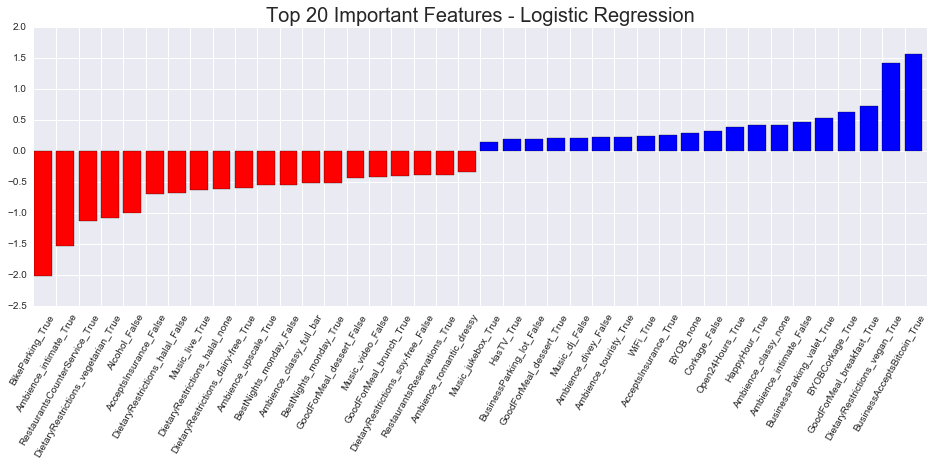

In [485]:
# plot top 20 important features
label, df_lr_impfeatures = plot_coefficients(models[0], labels[0], X_train.columns.values)

In [486]:
print label
df_lr_impfeatures

Logistic Regression


,top_pos_features,top_pos_coef,top_neg_features,top_neg_coef
0,Music_jukebox_True,0.147195,BikeParking_True,-2.02343
1,HasTV_True,0.183261,Ambience_intimate_True,-1.52782
2,BusinessParking_lot_False,0.184873,RestaurantsCounterService_True,-1.12724
3,GoodForMeal_dessert_True,0.206868,DietaryRestrictions_vegetarian_True,-1.08315
4,Music_dj_False,0.214629,Alcohol_False,-1.00358
5,Ambience_divey_False,0.223113,AcceptsInsurance_False,-0.700886
6,Ambience_touristy_True,0.228778,DietaryRestrictions_halal_False,-0.678505
7,WiFi_True,0.246436,Music_live_True,-0.639322
8,AcceptsInsurance_True,0.259693,DietaryRestrictions_halal_none,-0.616209
9,BYOB_none,0.285319,DietaryRestrictions_dairy-free_True,-0.605563


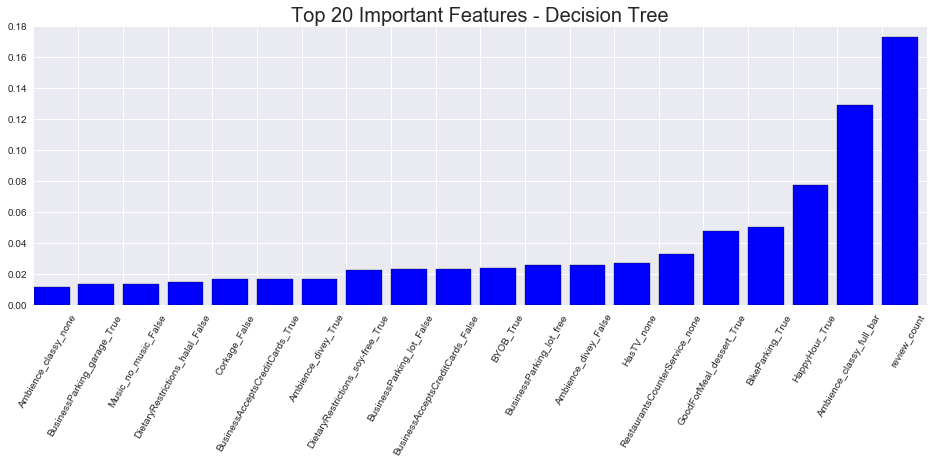

In [487]:
###### Decision Tree #######
label, df_dt_impfeatures = plot_coefficients(models[1], labels[1], X_train.columns.values)

In [488]:
print label
df_dt_impfeatures

Decision Tree


,top_pos_features,top_pos_coef
0,Ambience_classy_none,0.0117302
1,BusinessParking_garage_True,0.0138583
2,Music_no_music_False,0.0140212
3,DietaryRestrictions_halal_False,0.0149907
4,Corkage_False,0.0170498
5,BusinessAcceptsCreditCards_True,0.0171505
6,Ambience_divey_True,0.0172003
7,DietaryRestrictions_soy-free_True,0.0227405
8,BusinessParking_lot_False,0.0232321
9,BusinessAcceptsCreditCards_False,0.0234581


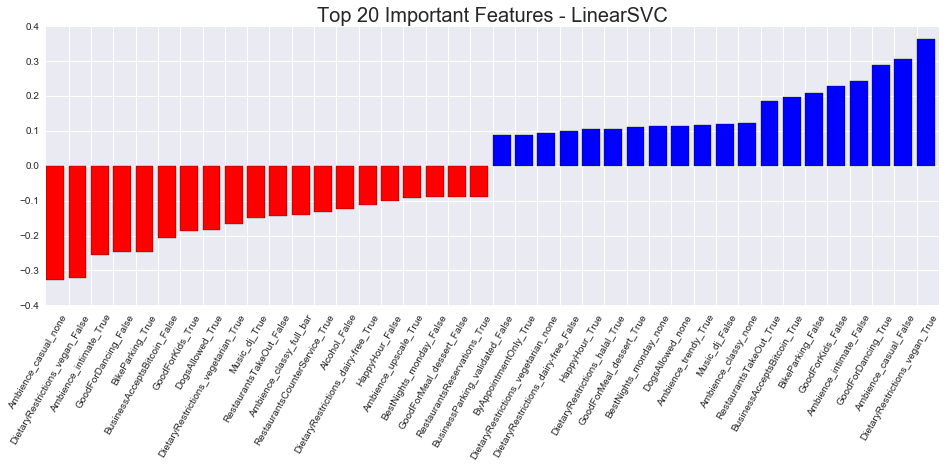

In [489]:
###### SVM #########
label, df_svc_impfeatures = plot_coefficients(models[2][0], labels[2][0], X_train.columns.values)

In [490]:
print label
df_svc_impfeatures

LinearSVC


,top_pos_features,top_pos_coef,top_neg_features,top_neg_coef
0,BusinessParking_validated_False,0.0877111,Ambience_casual_none,-0.328464
1,ByAppointmentOnly_True,0.0887222,DietaryRestrictions_vegan_False,-0.322294
2,DietaryRestrictions_vegetarian_none,0.0931329,Ambience_intimate_True,-0.2563
3,DietaryRestrictions_dairy-free_False,0.0994974,GoodForDancing_False,-0.247681
4,HappyHour_True,0.1042,BikeParking_True,-0.246135
5,DietaryRestrictions_halal_True,0.104797,BusinessAcceptsBitcoin_False,-0.208422
6,GoodForMeal_dessert_True,0.111688,GoodForKids_True,-0.187429
7,BestNights_monday_none,0.113802,DogsAllowed_True,-0.183979
8,DogsAllowed_none,0.113924,DietaryRestrictions_vegetarian_True,-0.166513
9,Ambience_trendy_True,0.117577,Music_dj_True,-0.149369


In [491]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 8

#### Plot One model - train & validation sets ####
def plot_ROC(model, Y_train, X_train, Y_vali, X_vali, label):
    print ("AUC on the %s Train data = %.5f" % \
           (label, metrics.roc_auc_score(model.predict(X_train), Y_train)))
    print ("AUC on the %s Validation data = %.5f\n" % \
           (label, metrics.roc_auc_score(model.predict(X_vali), Y_vali)))

    #fpr, tpr, thresholds = metrics.roc_curve(Y_train, model.predict_proba(X_train)[:,1])    
    #plt.plot(fpr, tpr, label='{} Train set'.format(label))
    
    fpr, tpr, thresholds = metrics.roc_curve(Y_vali, model.predict_proba(X_vali)[:,1])    
    plt.plot(fpr, tpr, label='{} Validation set'.format(label))
    
    plt.xlabel("false-positive rate", size=18)
    plt.ylabel("true-positibe rate", size=18)
    plt.title("ROC Curve of {} Model".format(label), size=20)
    plt.legend(loc='best')

    
##### more than one model - validation sets #####
def plot_ROCs(models, Y_trains, X_trains, Y_valis, X_valis, labels):  
    for model, Y_train, X_train, Y_vali, X_vali, label in \
    zip(models, Y_trains, X_trains, Y_valis, X_valis, labels):
        
        print ("AUC on the %s Train data = %.5f" % \
               (label, metrics.roc_auc_score(model.predict(X_train), Y_train)))
        print ("AUC on the %s Validation data = %.5f\n" % \
               (label, metrics.roc_auc_score(model.predict(X_vali), Y_vali)))
        
        fpr, tpr, thresholds = metrics.roc_curve(Y_vali, model.predict_proba(X_vali)[:,1])
        plt.plot(fpr, tpr, label=label)
    
    plt.xlabel("fpr", size=18)
    plt.ylabel("tpr", size=18)
    plt.title("ROC Curves for Models and Validation sets", size=20)
    plt.legend(loc='best')


AUC on the LR Train data = 0.70919
AUC on the LR Validation data = 0.74669



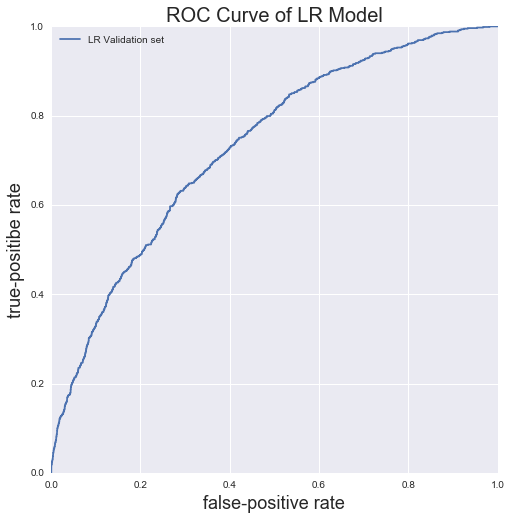

In [492]:
plot_ROC(lr_opt, Y_train, X_train, Y_vali, X_vali, label='LR')

In [493]:
models_roc = [models[0],models[1],models[2][1]]
labels_roc = [labels[0],labels[1],labels[2][1]]

In [494]:
labels_roc

['Logistic Regression', 'Decision Tree', 'SVM Calibrated Classifier']

In [495]:
models_roc

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=99, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=266,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=28,
             min_samples_split=14, min_weight_fraction_leaf=0.0,
             presort=False, random_state=99, splitter='best'),
 CalibratedClassifierCV(base_estimator=LinearSVC(C=0.23965103644177568, class_weight=None, dual=True,
      fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
      max_iter=1000, multi_class='ovr', penalty='l2', random_state=99,
      tol=0.0001, verbose=0),
             cv=3, method='sigmoid')]

AUC on the Logistic Regression Train data = 0.70919
AUC on the Logistic Regression Validation data = 0.74669

AUC on the Decision Tree Train data = 0.73967
AUC on the Decision Tree Validation data = 0.66968



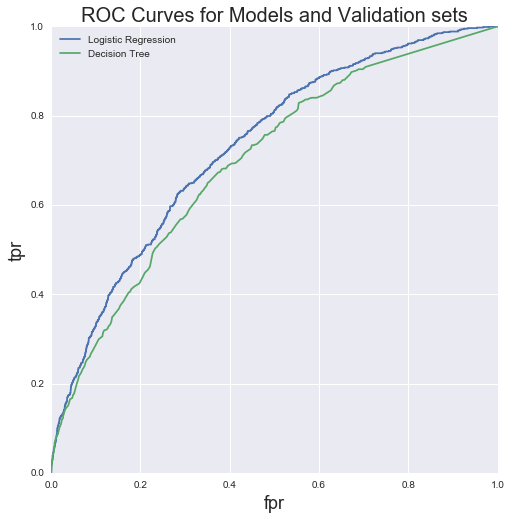

In [496]:
plot_ROCs(models_roc[:2], [Y_train]*2, [X_train]*2, [Y_vali]*2, [X_vali]*2, labels_roc[:2])

AUC on the Logistic Regression Train data = 0.70919
AUC on the Logistic Regression Validation data = 0.74669

AUC on the Decision Tree Train data = 0.73967
AUC on the Decision Tree Validation data = 0.66968

AUC on the SVM Calibrated Classifier Train data = 0.72088
AUC on the SVM Calibrated Classifier Validation data = 0.80351



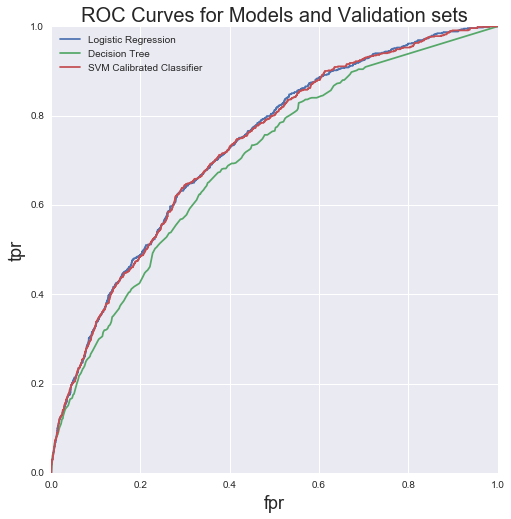

In [497]:
# Plot AUC for DT, LR, SVC optimal models
plot_ROCs(models_roc, [Y_train]*3, [X_train]*2+[X_train_std], [Y_vali]*3, [X_vali]*2+[X_vali_std], labels_roc)
